# Imports, Physical Channels, Qubit Definitions, Functions
Always run this section

To reproduce error, start on T0, measure spectrum, then move to F0 with drive lo at 6e9 and ge at 2e9

In [1]:
from pathlib import Path
import datetime
from datetime import date
import pandas as pd
import time
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import logging
import math as m
import statistics as stat

from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from laboneq.simple import *
import laboneq.pulse_sheet_viewer.pulse_sheet_viewer as psv
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)

-AWG1 (SGCHANNELS/0/OUTPUT) - C2 - GKP1 Flux/Drive

-AWG2 (SGCHANNELS/1/OUTPUT) - C1 - GKP2 Flux/Drive

-AWG3 (SGCHANNELS/2/OUTPUT) - C7 - GKP1 Drive

In [2]:
# Just be careful about the drive lines.
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH

connections:
  device_shfqc:
    - iq_signal: T1/drive_line
      ports: SGCHANNELS/3/OUTPUT
    
    - iq_signal: T1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: T1/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
    - iq_signal: T0/drive_line
      ports: SGCHANNELS/1/OUTPUT

    - iq_signal: T0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: T0/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
    - iq_signal: F0/drive_line
      ports: SGCHANNELS/3/OUTPUT
      
    - iq_signal: F0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: F0/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
    - iq_signal: F1/drive_line
      ports: SGCHANNELS/1/OUTPUT
      
    - iq_signal: F1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: F1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    
    - iq_signal: GKP1/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: GKP1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: GKP1/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: GKP2/drive_line
      ports: SGCHANNELS/1/OUTPUT

    - iq_signal: GKP2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: GKP2/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
    - iq_signal: GKP3/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: GKP3/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: GKP3/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
"""

The logical signal group is what defines the set of logical parameters for measurements. This needs to get assigned to an experimental signal group in the Experiment class connecting theory with device_setup (shown later).

In [3]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc, # the yaml gives the full description of the logical signal layout
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

# Qubit Parameters

In [12]:
GKP1 = Transmon.from_logical_signal_group(
    uid="GKP1",
    lsg=device_setup.logical_signal_groups["GKP1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=4.5e9,
        readout_resonator_frequency=7.112e9,
        readout_lo_frequency=7.2e9,
        readout_integration_delay=95e-9,
        readout_range_out=-10,
        readout_range_in=5,
        drive_lo_frequency=4.4e9,
        drive_range=0,
        user_defined={
            "amplitude_pi": 1,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.7,
            "reset_length": 5e-6,
        }
    )
)

GKP2 = Transmon.from_logical_signal_group(
    uid='GKP2',
    lsg=device_setup.logical_signal_groups['GKP2'],
    parameters=TransmonParameters(
        resonance_frequency_ge=3e9,
        readout_resonator_frequency=7.304e9,
        readout_lo_frequency=7.2e9,
        readout_integration_delay=95e-9,
        readout_range_out=-5,
        readout_range_in=5,
        drive_lo_frequency=3e9,
        drive_range=10,
        user_defined={
            'amplitude_pi': 1,
            'pulse_length': 100e-9,
            'readout_len': 2e-6,
            'readout_amp': 0.8,
            'reset_length': 2e-6
        }
    )
)

GKP3 = Transmon.from_logical_signal_group(
    uid='GKP3',
    lsg=device_setup.logical_signal_groups['GKP3'],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.9,
        readout_resonator_frequency=7.48e9,
        readout_lo_frequency=7.4e9,
        readout_integration_delay=95e-9,
        readout_range_out=-10,
        readout_range_in=5,
        drive_lo_frequency=3e9,
        drive_range=0,
        user_defined={
            'amplitude_pi': 1,
            'pulse_length': 50e-9,
            'readout_len': 2e-6,
            'readout_amp': 1,
            'reset_length': 5e-6
        }
    )
)
T0 = Transmon.from_logical_signal_group(
    uid="T0",
    lsg=device_setup.logical_signal_groups["T0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=4.919995e9,
        readout_resonator_frequency=6.4208e9,
        readout_lo_frequency=6.4e9,
        readout_integration_delay=95e-9,
        readout_range_out=0,
        readout_range_in=5,
        drive_lo_frequency=4.8e9,
        drive_range=-5,
        user_defined={
            "amplitude_pi/2": 0.49,
            "amplitude_pi": 0.82,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 1,
            "reset_length": 300e-6,
        }
    )
)

T1 = Transmon.from_logical_signal_group(
    uid='T1',
    lsg=device_setup.logical_signal_groups['T1'],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.319995e9,
        readout_resonator_frequency=6.5882e9,
        readout_lo_frequency=6.4e9,
        readout_integration_delay=95e-9,
        readout_range_out=10, #0,
        readout_range_in=5,
        drive_lo_frequency=3.2e9,
        drive_range=10,
        user_defined={
            'amplitude_pi': 0.5,
            'amplitude_pi/2': 0.86,
            'pulse_length': 100e-9,
            'readout_len': 2e-6,
            'readout_amp': 0.4,
            'reset_length': 10e-6,
        }
    )
)
            
F0 = Transmon.from_logical_signal_group( 
    uid="F0",
    lsg=device_setup.logical_signal_groups["F0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=4.063e9,
        readout_resonator_frequency=6.7624e9,
        readout_lo_frequency=6.8e9,
        readout_integration_delay=120e-9,
        readout_range_out=-5,
        readout_range_in=5,
        drive_lo_frequency=4e9,
        drive_range=5,
        user_defined={
            "amplitude_pi": 0.425,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 1,
            "reset_length": 10e-6,
        }
    )
)

F1 = Transmon.from_logical_signal_group(
    uid='F1',
    lsg=device_setup.logical_signal_groups['F1'],
    parameters=TransmonParameters(
        resonance_frequency_ge=4e9,
        readout_resonator_frequency=6.8882e9,
        readout_lo_frequency=6.8e9,
        readout_integration_delay=93e-9,
        readout_range_out=0,
        readout_range_in=5,
        drive_lo_frequency=4e9,
        drive_range=10,
        user_defined={
            'amplitude_pi': 0.5,
            'pulse_length': 100e-9,
            'readout_len': 2e-6,
            'readout_amp': 0.6,
            'reset_length': 5e-6,
        }
    )
)

qubit=T0 #Defines which qubit we are actually doing all the measuring of. Important.
averages=2**10
device_setup.set_calibration(qubit.calibration()) #This sets the settings defined in the qubit params
# device_setup.get_calibration() #Here for checking if all the calibration went well.

readout_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=qubit.parameters.user_defined['readout_amp'],
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

# Connect to Yoko

In [32]:
try:
    dc = GS200('yoko_right', address = 'TCPIP0::192.168.4.157::inst0::INSTR')
except Exception as e:
    print(e)

try:
    coil= GS200('yoko_left', address = 'TCPIP0::192.168.4.208::inst0::INSTR')
except Exception as e:
    print(e)

Connected to: YOKOGAWA GS210 (serial:91S621541, firmware:2.02) in 0.05s
Connected to: YOKOGAWA GS210 (serial:91PC11413, firmware:2.02) in 0.03s


In [34]:
# dc.BNC_out.set('ready') # this sets a low signal signaure right after the move has been completed
# dc.BNC_out.get()
# dc.ramp_current(0e-3, 1e-6,0.02)
# dc.output('off')
# dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0.02)
dc.output('on')
dc.current_range(0.01)

# coil.BNC_out.set('ready') # this sets a low signal signature right after the move has been completed
# coil.BNC_out.get()
# coil.ramp_current(0e-3, 1e-6,0.02)
# coil.output('off')
# coil.source_mode('CURR')
coil.ramp_current(0e-3, 1e-6,0.02)
coil.output('on')
coil.current_range(0.01)

# dc.current.get()
# coil.current.get()

In [112]:
coil.ramp_current(465e-6, 1e-6, 0.01)

# Defining Functions

Defining functions for plotting statistics

In [5]:
def plot_box_whisker_time_series(datetime_array, float_array, t_type_str: str, time_interval_str='2min'):
    # Convert arrays to pandas DataFrame
    data = pd.DataFrame({'time': datetime_array, 'value': float_array})
    
    # Set the datetime column as index
    data.set_index('time', inplace=True)
    
    # Resample the data in 10-minute intervals and aggregate into lists
    data_10min = data.resample(time_interval_str).apply(list) #change this to change the re-sampling times and such
    
    # Drop intervals with no data
    data_10min.dropna(inplace=True)
    
    # Prepare data for plotting
    time_labels = data_10min.index
    float_data_per_interval = data_10min['value']
    
    # Create boxplot
    plt.figure(figsize=(16, 6))
    plt.boxplot(float_data_per_interval, positions=range(len(time_labels)), widths=0.7)
    
    # Customize x-axis with datetime labels
    plt.xticks(ticks=range(len(time_labels)), labels=time_labels.strftime('%H:%M'), rotation=45)
    plt.xlabel('Time (Intervals)')
    plt.ylabel(f'{t_type_str} (us)')
    plt.title(f'{t_type_str} Times over Time')
    
    plt.tight_layout()
    plt.show()

def measure_data_stats(T_run, data_points):
    fit_out = np.empty(data_points)
    datetime_array = np.empty((data_points), dtype=datetime.datetime)
    for i in range(data_points):
        try:
            t_data, _ = T_run()
            print(i+1, 1/t_data*1e6)
        except:
            t_data = None
            print('t_data failed')
        datetime_array[i] = datetime.datetime.now()
        fit_out[i] = t_data
    return [datetime_array, fit_out]

def stat_out(data, t_type_str: str):
    mean = np.mean(data)
    std = np.std(data)
    print(t_type_str, ' = ', str(mean), '+/-', str(std))
    return [mean, std]

Real time calls: Seems as if the QCoDes intruments cannot be pickled into the experiment when it is sent to the HFSQC. To get around this, do not pass the QCoDes object as a parameter to the call. Just have that name be in the global namespace which makes sure it is handled by the computer.

In [6]:
def change_dc_current(session, new_current, step_time):
    dc.ramp_current(new_current, 10e-6, step_time)
    # print("DC Current " + str(new_current))

def change_coil_current(session, new_current, step_time):
    coil.ramp_current(new_current, 1e-6, step_time)
    print("Current coil current: " + str(new_current))
    
def sweep_progress(session, linearsweepparameter):
    print(str(linearsweepparameter.count))

# Single Resonator Point Pulsed Measurement

In [49]:
# Is now working now that there is a kernel for the integration (in integration mode). For ease, I am having the kernel be the same as the applied drive pulse.
exp = Experiment(
    uid="Single Point Readout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.section(uid="Pulsed Single Frequency Readout"):
        exp.play(
            signal="measure",
            pulse=readout_pulse
        )
        exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
            signal='acquire',
            handle='single_freq_data',
            length=qubit.parameters.user_defined['readout_len'],
            kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
        )
    with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
        exp.reserve(signal='measure')

## Compile Session
Do final checks before running the job.

In [50]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [51]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [52]:
# Just one data point... so not much to see here...
print(np.abs(my_acquired_results.data))
my_acquired_results

30.839472115059007


AcquiredResult(data=(26.247333721564917-16.19106274598129j), axis_name=[], axis=[], last_nt_step=[], handle='single_freq_data')

# Readout Resonator Trace (Global)

In [149]:
# Full frequency span for readout resonator
readout_lo_freq_sweep = LinearSweepParameter(
    uid='Readout_LO', start=4e9, stop=8e9, count=5)

readout_freq_sweep = LinearSweepParameter(
    uid='Readout_Frequency', start=-500e6, stop=495e6, count=101)

exp = Experiment(
    uid="Resonator Trace",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)
with exp.sweep(
    uid='Readout LO Frequency Sweep',
    parameter=readout_lo_freq_sweep
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp.sweep(
            uid='Readout Frequency Sweep',
            parameter=readout_freq_sweep,
            reset_oscillator_phase=True
        ):
            with exp.section(uid="Pulsed Single Frequency Readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse
                )
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=readout_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
readout_lo = Oscillator(
    "readout_lo",
    frequency=readout_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,
    local_oscillator=readout_lo)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,
    local_oscillator=readout_lo)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [150]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [151]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [152]:
lo_array = my_acquired_results.axis[0]
AWG_freqs = my_acquired_results.axis[1]
freqs = np.empty((0))
for lo in lo_array:
    freqs = np.append(freqs, lo + AWG_freqs,)

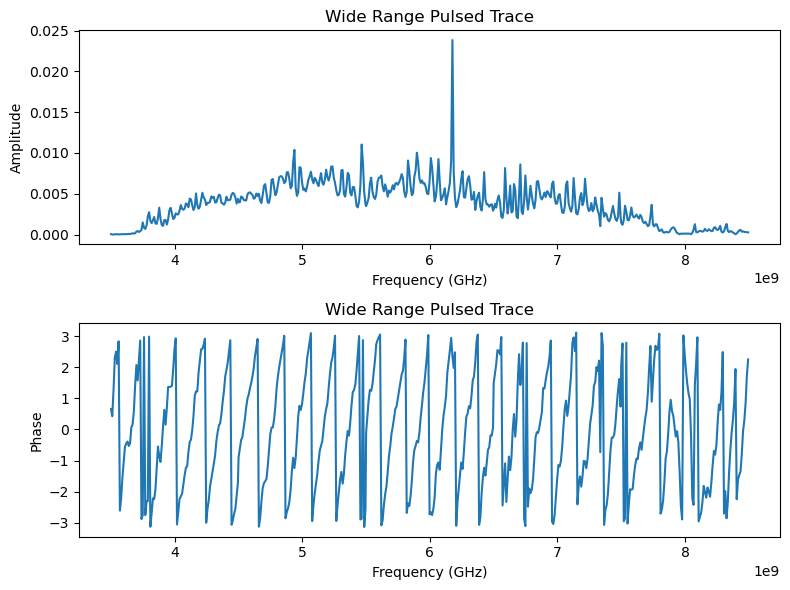

In [153]:
# For plotting current vs single resonator point
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title('Wide Range Pulsed Trace')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[1].plot(freqs, phase)
ax[1].set_title('Wide Range Pulsed Trace')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase')
fig.tight_layout()

# Readout Resonator Trace (Localized)
- Actually just works to put in the frequency values for start and stop. The LO will adjust as necessary on the backend. Nice.

In [39]:
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-5e6,
    stop=lo_freq_offset+5e6,
    count=101)

exp = Experiment(
    uid="Resonator Trace",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
):
    with exp.sweep(
        uid='Readout Frequency Sweep',
        parameter=ro_frequency_sweep,
        reset_oscillator_phase=True
    ):
        with exp.section(uid="Pulsed Single Frequency Readout"):
            exp.play(
                signal="measure",
                pulse=readout_pulse
            )
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE,)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [40]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [41]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

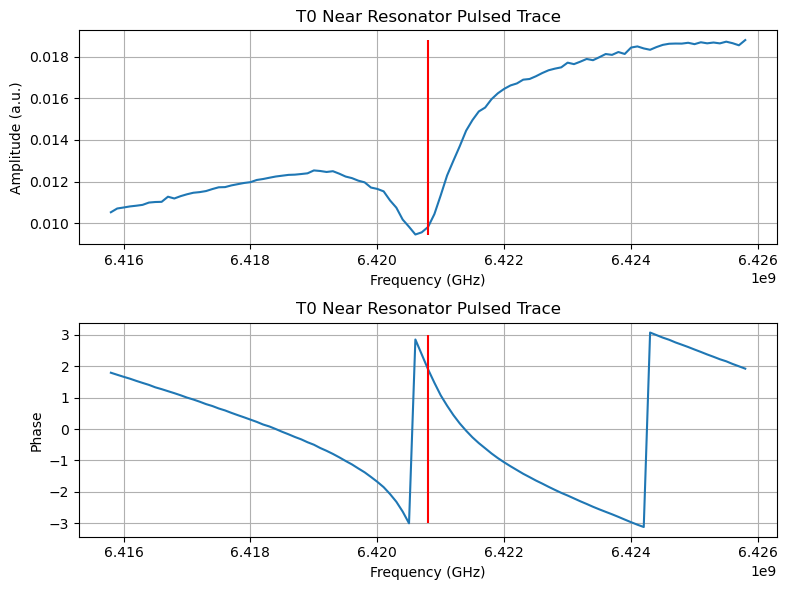

In [43]:
# For plotting current vs single resonator point
freqs = my_acquired_results.axis[0] + qubit.parameters.readout_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Near Resonator Pulsed Trace')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].grid()
ax[1].plot(freqs, phase)
ax[1].set_title(f'{qubit.uid} Near Resonator Pulsed Trace')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()
ax[0].vlines(qubit.parameters.readout_resonator_frequency, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].vlines(qubit.parameters.readout_resonator_frequency, -3, 3, colors='r');

# Punchout
This works, but the power sweep is NEAR_TIME. Putting it in the REAL_TIME section makes the play channel seem like there are multiple envelopes for the readout pulse? Might be becasue of some timing or alignement issue... For now it seems fine given that the loop only needs to be executed a handful of times.

In [19]:
#Note this is a power sweep of the pulse amplitude, not of powers! The conversion from amplitude to powers is squared.
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

readout_pulse_punchout = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=1,
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-9e6,
    stop=lo_freq_offset+9e6,
    count=51) 

power_sweep = SweepParameter(
    uid='Readout_Power', values=np.logspace(start=-2,stop=0,num=20,base=10))

exp = Experiment(
    uid="Punchout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Power sweep',
    parameter=power_sweep,
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
    
        with exp.sweep(
            uid='Readout_Frequency_Sweep',
            parameter=ro_frequency_sweep,
            reset_oscillator_phase=True
        ):
            with exp.section(uid="single_res_point_readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse_punchout,
                    amplitude=power_sweep,
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [20]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [21]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

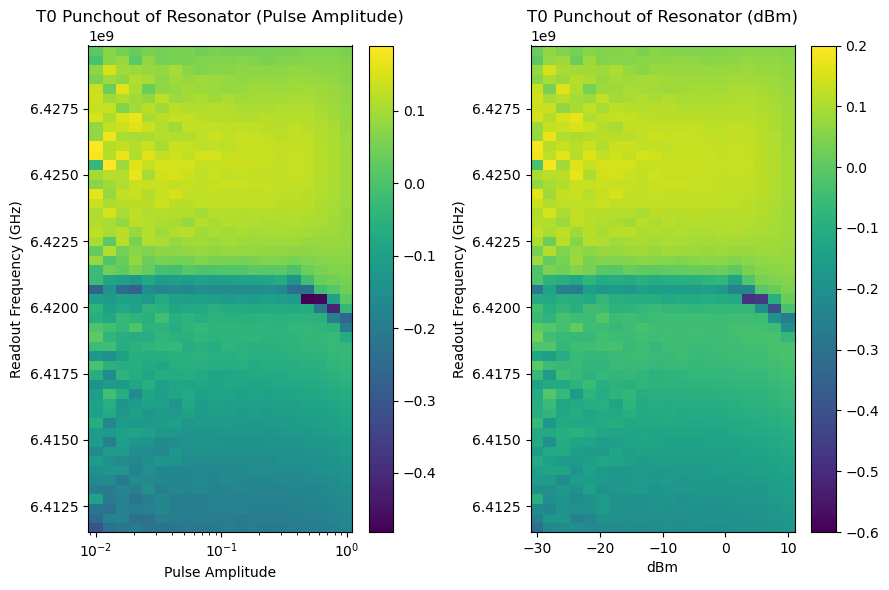

In [22]:
# For plotting punchout
IQ_data = my_acquired_results.data
phase_data = np.angle(IQ_data)
normalized_amp_data = np.divide(np.abs(IQ_data).T, np.mean(np.abs(IQ_data), axis=1))
normalized_dB_data = np.log10(normalized_amp_data)

amplitude = my_acquired_results.axis[0]
power = 10*np.log10(amplitude**2)+qubit.parameters.readout_range_out

RO_freqs = my_acquired_results.axis[1]+qubit.parameters.readout_lo_frequency

graphing_data = normalized_dB_data #could be the phase_data too
fig, ax = plt.subplots(1,2, figsize=(9,6))
cmap0 = ax[0].pcolor(amplitude,
             RO_freqs,
             graphing_data,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Punchout of Resonator (Pulse Amplitude)')
ax[0].set_xlabel('Pulse Amplitude')
ax[0].set_ylabel('Readout Frequency (GHz)')
ax[0].set_xscale('log')
cmap1 = ax[1].pcolor(power,
             RO_freqs,
             graphing_data,
             shading='nearest',
             vmin=-0.6,
             vmax=0.2,)
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
ax[1].set_title(f'{qubit.uid} Punchout of Resonator (dBm)')
ax[1].set_xlabel('dBm')
ax[1].set_ylabel('Readout Frequency (GHz)')
fig.tight_layout()

# 1D Flux Sweep

In [288]:
dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=0e-6, stop=4e-6, count=5)

coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=-300e-6, stop=300e-6, count=101)

In [293]:
# This one is a direct copy of my working spectroscopy scan but now includes a 1D resonator sweep.
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-3e6,
    stop=lo_freq_offset+3e6,
    count=101) #NOTE! This is the frequency offset from the LO. Need better integration for ease of use.

dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=-300e-6, stop=300e-6, count=201)

coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=250e-6, stop=650e-6, count=201)

current_sweep_param = coil_sweep_param #Simply change coil_sweep_param to dc_sweep param for dc sweep.

exp = Experiment(
    uid="1D Current vs Resonator",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid="Yoko Sweep",
    parameter=current_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('change_current', new_current=current_sweep_param, step_time=0.01) 
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp.sweep(
                uid='Readout Resonator Frequency Sweep',
                parameter=ro_frequency_sweep,
                reset_oscillator_phase=True
            ):
                with exp.section(uid="Pulsed Single Frequency Readout"):
                    exp.play(
                        signal="measure",
                        pulse=readout_pulse
                    )
                    exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                        signal='acquire',
                        handle='single_freq_data',
                        length=qubit.parameters.user_defined['readout_len'],
                    )
                with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                    exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [294]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'change_current')
session.register_neartime_callback(change_coil_current, 'change_current')
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [295]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

Current coil current: 0.00025
Current coil current: 0.000252
Current coil current: 0.000254
Current coil current: 0.000256
Current coil current: 0.000258
Current coil current: 0.00026000000000000003
Current coil current: 0.000262
Current coil current: 0.000264
Current coil current: 0.000266
Current coil current: 0.000268
Current coil current: 0.00027
Current coil current: 0.000272
Current coil current: 0.000274
Current coil current: 0.000276
Current coil current: 0.000278
Current coil current: 0.00028
Current coil current: 0.000282
Current coil current: 0.000284
Current coil current: 0.000286
Current coil current: 0.000288
Current coil current: 0.00029
Current coil current: 0.000292
Current coil current: 0.000294
Current coil current: 0.000296
Current coil current: 0.000298
Current coil current: 0.00030000000000000003
Current coil current: 0.000302
Current coil current: 0.000304
Current coil current: 0.000306
Current coil current: 0.000308
Current coil current: 0.00031
Current coil cur

## Plot and Analyze Data

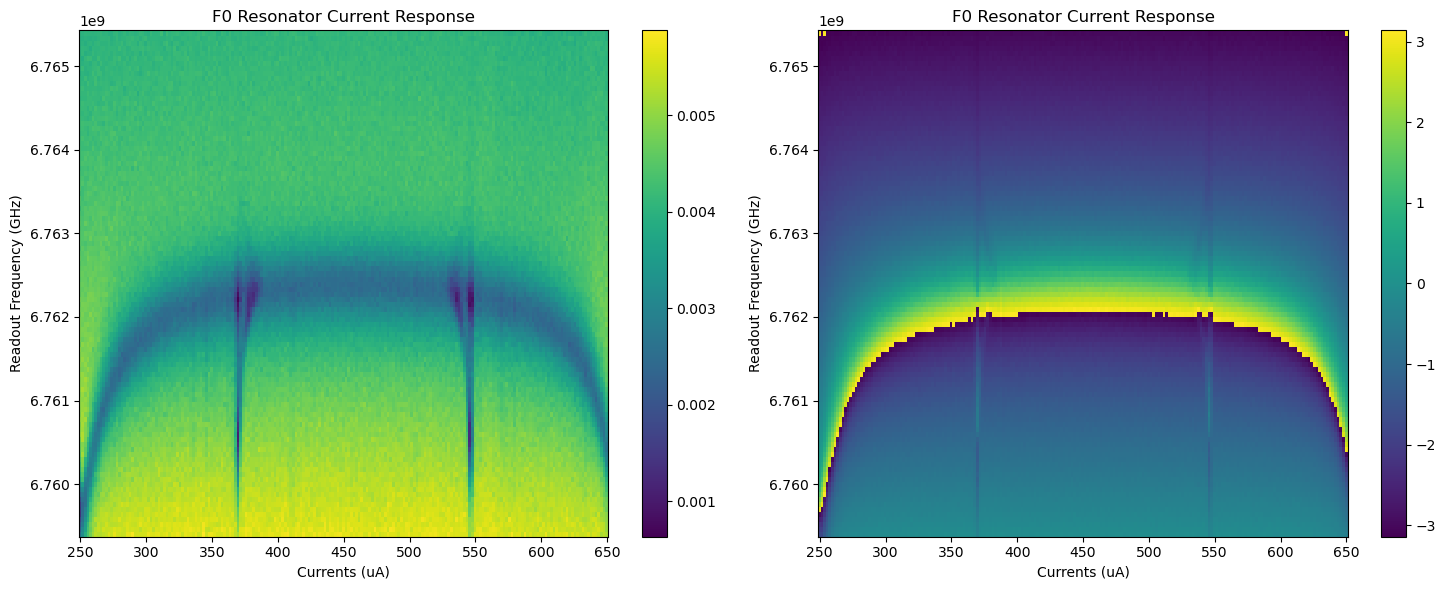

In [296]:
# For plotting 1D flux sweep
amplitude = np.abs(my_acquired_results.data)
phase = np.angle(my_acquired_results.data)
currents = my_acquired_results.axis[0]*1e6
freqs = my_acquired_results.axis[1] + qubit.parameters.readout_lo_frequency

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(currents,
             freqs,
             amplitude.T,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator Current Response')
ax[0].set_xlabel('Currents (uA)')
ax[0].set_ylabel('Readout Frequency (GHz)')
cmap1 = ax[1].pcolor(currents,
             freqs,
             phase.T,
             shading='nearest',)
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
ax[1].set_title(f'{qubit.uid} Resonator Current Response')
ax[1].set_xlabel('Currents (uA)')
ax[1].set_ylabel('Readout Frequency (GHz)')
fig.tight_layout()

# 2D Flux Sweep (Inner loop is DC, Outer loop is Coil)
- Would be nice to have a faster flux sweep functionality at the end (or beginning?) of each loop

In [336]:
dc_sweep_param = LinearSweepParameter(
    uid='DC_Current', start=-2000e-6, stop=2000e-6, count=301)

coil_sweep_param = LinearSweepParameter(
    uid='Coil_Current', start=-150e-6, stop=150e-6, count=301)

exp = Experiment(
    uid="2D Current Sweep",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='coil sweep',
    parameter=coil_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('Coil_Current', new_current=coil_sweep_param, step_time=0.01)
    with exp.sweep(
        uid="dc sweep",
        parameter=dc_sweep_param,
        execution_type=ExecutionType.NEAR_TIME,
    ):
        exp.call('DC_Current', new_current=dc_sweep_param, step_time=0.01) #note that "argument" session (first argument to the function) is automatically passed
        with exp.acquire_loop_rt(
            uid="shots",
            count=averages,
            acquisition_type=AcquisitionType.INTEGRATION,
            averaging_mode=AveragingMode.SEQUENTIAL
        ):
            with exp.section(uid="Pulsed Single Frequency Readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    kernel=readout_pulse,
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

## Compile Session
Do final checks before running the job.

In [337]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'DC_Current')
session.register_neartime_callback(change_coil_current, 'Coil_Current')
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=1000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [338]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

Current coil current: -0.00015
Current coil current: -0.000149
Current coil current: -0.000148
Current coil current: -0.000147
Current coil current: -0.000146
Current coil current: -0.000145
Current coil current: -0.00014399999999999998
Current coil current: -0.00014299999999999998
Current coil current: -0.00014199999999999998
Current coil current: -0.00014099999999999998
Current coil current: -0.00014
Current coil current: -0.000139
Current coil current: -0.000138
Current coil current: -0.000137
Current coil current: -0.000136
Current coil current: -0.00013499999999999997
Current coil current: -0.00013399999999999998
Current coil current: -0.00013299999999999998
Current coil current: -0.00013199999999999998
Current coil current: -0.00013099999999999999
Current coil current: -0.00013
Current coil current: -0.000129
Current coil current: -0.000128
Current coil current: -0.000127
Current coil current: -0.00012599999999999997
Current coil current: -0.000125
Current coil current: -0.000123

## Plot and Analyze Data
TODO: Properly Plot

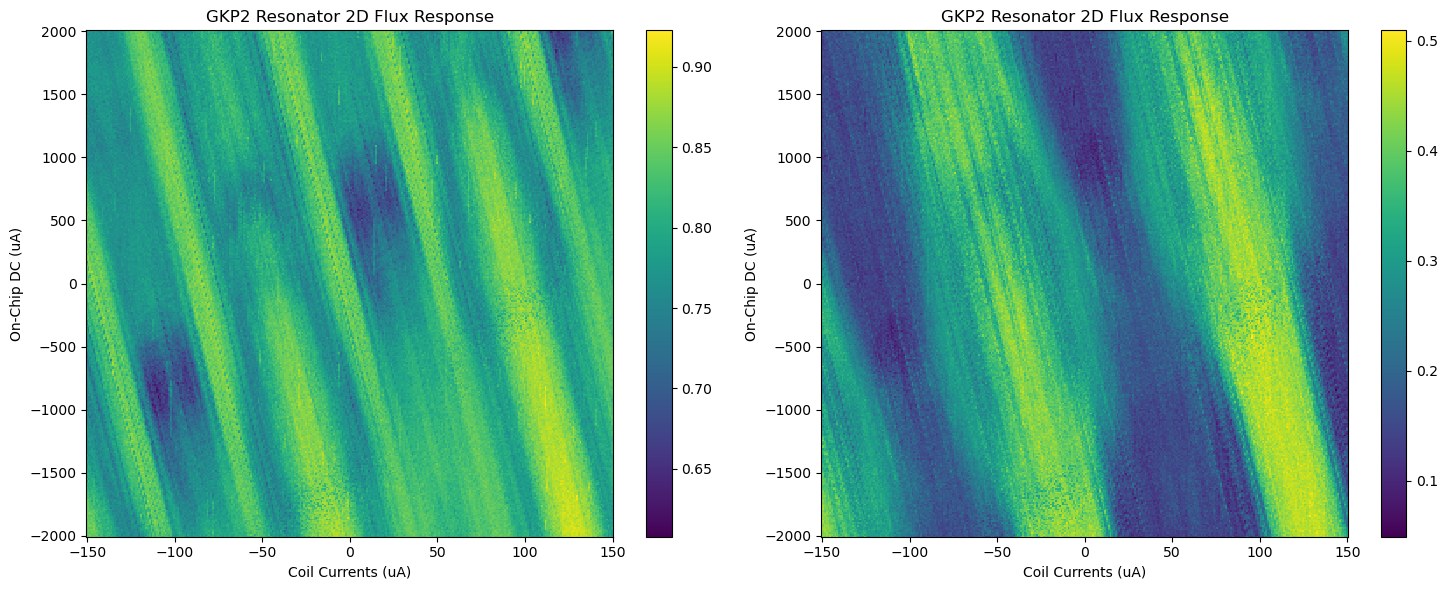

In [341]:
#plotting resonator over flux
amp_data = np.abs(my_acquired_results.data)
phase_data = np.angle(my_acquired_results.data)
db_data = np.log10(amp_data)

coil_currents = my_acquired_results.axis[0]
dc_currents = my_acquired_results.axis[1]

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(coil_currents*1e6,
             dc_currents*1e6,
             db_data.T,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator 2D Flux Response')
ax[0].set_xlabel('Coil Currents (uA)')
ax[0].set_ylabel('On-Chip DC (uA)')
cmap1 = ax[1].pcolor(coil_currents*1e6,
             dc_currents*1e6,
             phase_data.T,
             shading='nearest')
ax[1].set_title(f'{qubit.uid} Resonator 2D Flux Response')
ax[1].set_xlabel('Coil Currents (uA)')
ax[1].set_ylabel('On-Chip DC (uA)')
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
fig.tight_layout()

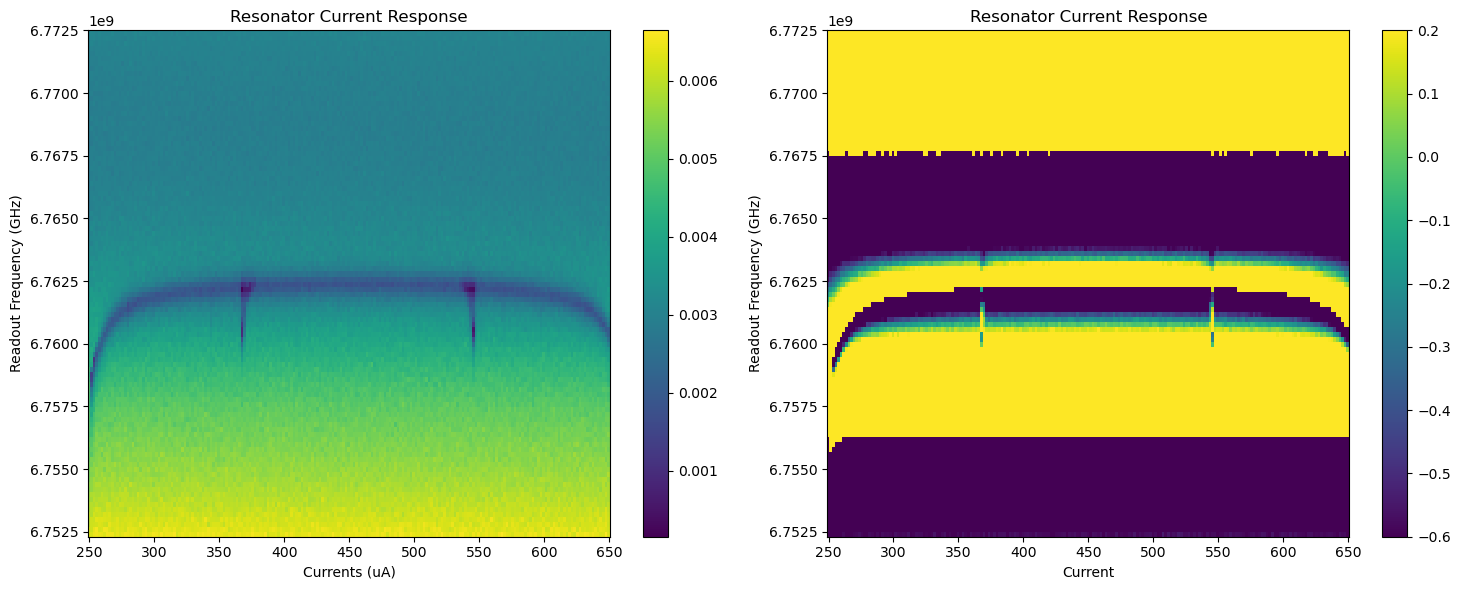

In [111]:
amplitude = np.abs(my_acquired_results.data)
phase = np.angle(my_acquired_results.data)
currents = my_acquired_results.axis[0]*1e6
freqs = my_acquired_results.axis[1] + qubit.parameters.readout_lo_frequency

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(currents,
             freqs,
             amplitude.T,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator Current Response')
ax[0].set_xlabel('Currents (uA)')
ax[0].set_ylabel('Readout Frequency (GHz)')
cmap1 = ax[1].pcolor(currents,
             freqs,
             phase.T,
             shading='nearest',
             vmin=-0.6,
             vmax=0.2,)
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
ax[1].set_title(f'{qubit.uid} Resonator Current Response')
ax[1].set_xlabel('Currents (uA)')
ax[1].set_ylabel('Readout Frequency (GHz)')
fig.tight_layout()

# Qubit Spectroscopy (Global)
-Unclear still how to have the LO naturally move during the sweep. Maybe build it into a function call?
-For some reason, the drive frequency sweep is upset that it is in real-time. Need to investigate further.

In [320]:
drive_lo_freq_sweep = LinearSweepParameter(
    uid='Drive_LO', start=1e9, stop=8e9, count=8)

drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency', start=-500e6, stop=498e6, count=500)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Sweep Drive LO',
    parameter=drive_lo_freq_sweep
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Drive Frequency Sweep',
            parameter=drive_freq_sweep,
        ):
            with exp.section(uid='Play drive'):
                exp.play(
                    signal="drive",
                    pulse=pulse_library.gaussian_square(
                    uid=f"drive_pulse_{qubit.uid}",
                    length=100e-9,
                    width=100e-9*0.9,
                    sigma=0.2,
                    marker = {"marker1": {"enable": True}}))
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
drive_lo = Oscillator(
    'drive_lo',
    frequency=drive_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,
    local_oscillator=drive_lo)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [321]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [322]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [323]:
drive_lo_array = my_acquired_results.axis[0]
drive_AWG_freqs = my_acquired_results.axis[1]
drive_freqs = np.empty((0))
for drive_lo in drive_lo_array:
    drive_freqs = np.append(drive_freqs, drive_lo + drive_AWG_freqs,)

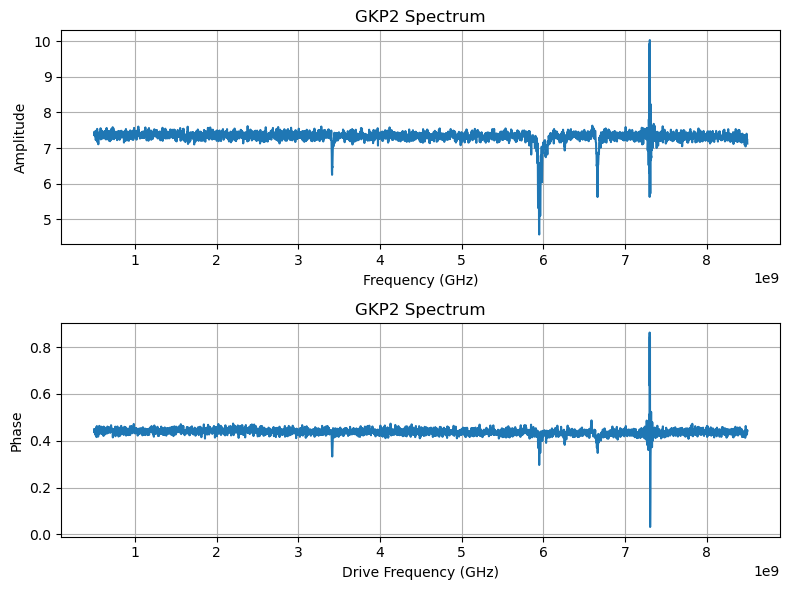

In [324]:
# For plotting current vs single resonator point
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(drive_freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
ax[1].plot(drive_freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()

In [371]:
exp.get_calibration()

Calibration(
│   calibration_items={
│   │   'measure': None,
│   │   'acquire': None,
│   │   'drive': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='drive_osc',
│   │   │   │   frequency=LinearSweepParameter(
│   │   │   │   │   uid='Drive_Frequency',
│   │   │   │   │   start=-500000000.0,
│   │   │   │   │   stop=498000000.0,
│   │   │   │   │   count=500,
│   │   │   │   │   axis_name=None
│   │   │   │   ),
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=None
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='drive_lo',
│   │   │   │   frequency=LinearSweepParameter(
│   │   │   │   │   uid='Drive_LO',
│   │   │   │   │   start=1000000000.0,
│   │   │   │   │   stop=8000000000.0,
│   │   │   │   │   count=8,
│   │   │   │   │   axis_name=None
│   │   │   │   ),
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=None
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=None,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None,
│   │   │   added_outputs=None,
│   │   │   automute=False
│   │   )
│   }
)

# Qubit Spectroscopy (Local)

In [15]:
device_setup.get_calibration();
exp.get_calibration();

ExperimentSignal(
│   uid='measure',
│   calibration=None,
│   mapped_logical_signal_path='/logical_signal_groups/T0/measure_line'
)

ExperimentSignal(
│   uid='acquire',
│   calibration=None,
│   mapped_logical_signal_path='/logical_signal_groups/T0/acquire_line'
)

ExperimentSignal(
│   uid='drive',
│   calibration=SignalCalibration(
│   │   oscillator=Oscillator(
│   │   │   uid='drive_osc',
│   │   │   frequency=LinearSweepParameter(
│   │   │   │   uid='Drive_Frequency',
│   │   │   │   start=69995000.0,
│   │   │   │   stop=169995000.0,
│   │   │   │   count=401,
│   │   │   │   axis_name=None
│   │   │   ),
│   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   carrier_type=None
│   │   ),
│   │   local_oscillator=None,
│   │   mixer_calibration=None,
│   │   precompensation=None,
│   │   port_delay=None,
│   │   port_mode=None,
│   │   delay_signal=None,
│   │   voltage_offset=None,
│   │   range=None,
│   │   threshold=None,
│   │   amplitude=None,
│   │   amplifier_pump=None,
│   │   added_outputs=None,
│   │   automute=False
│   ),
│   mapped_logical_signal_path='/logical_signal_groups/T0/drive_line'
)

[, , ]

In [58]:
drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency',
    start=qubit.parameters.drive_frequency_ge-500e6,
    stop=qubit.parameters.drive_frequency_ge+500e6,
    count=101
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.SEQUENTIAL,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Drive Frequency Sweep',
        parameter=drive_freq_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=1), #qubit.parameters.user_defined['amplitude_pi']), #max power to start
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [59]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [60]:
session.signal_map.items()

dict_items([('measure', '/logical_signal_groups/GKP2/measure_line'), ('acquire', '/logical_signal_groups/GKP2/acquire_line'), ('drive', '/logical_signal_groups/GKP2/drive_line')])

In [61]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

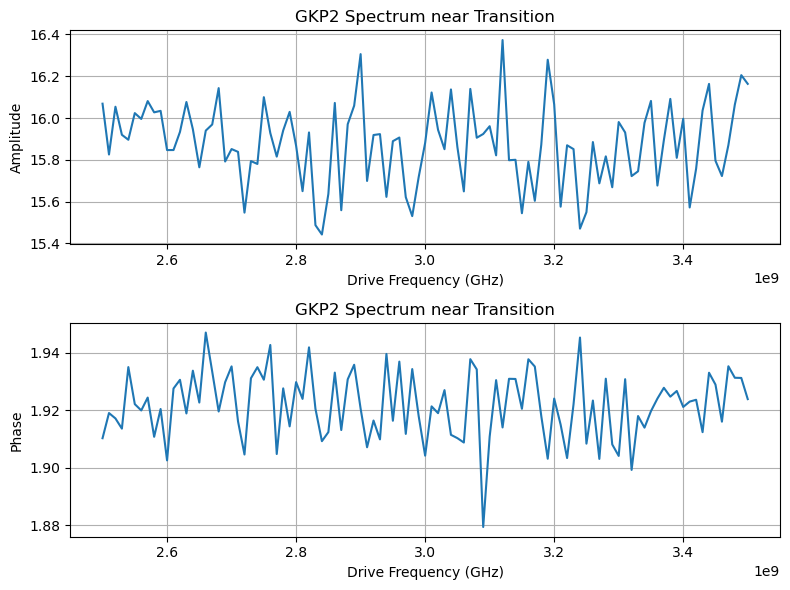

In [62]:
# For plotting current vs single resonator point
freqs = my_acquired_results.axis[0] + qubit.parameters.drive_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum near Transition')
ax[0].set_xlabel('Drive Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
# ax[0].vlines(qubit.parameters.drive_frequency_ge+qubit.parameters.drive_lo_frequency, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].plot(freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum near Transition')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
# ax[0].vlines(4.063e9, -3, 0, colors='r');
# ax[1].vlines(qubit.parameters.readout_resonator_frequency, -3, 0, colors='r')
fig.tight_layout()

# Low Frequency Qubit Spectroscopy

In [288]:
drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency',
    start=10e6,
    stop=1e9,
    count=991
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Drive Frequency Sweep',
        parameter=drive_freq_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=1), #qubit.parameters.user_defined['amplitude_pi']), #max power to start
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,
    port_mode=PortMode.LF)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [289]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [290]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

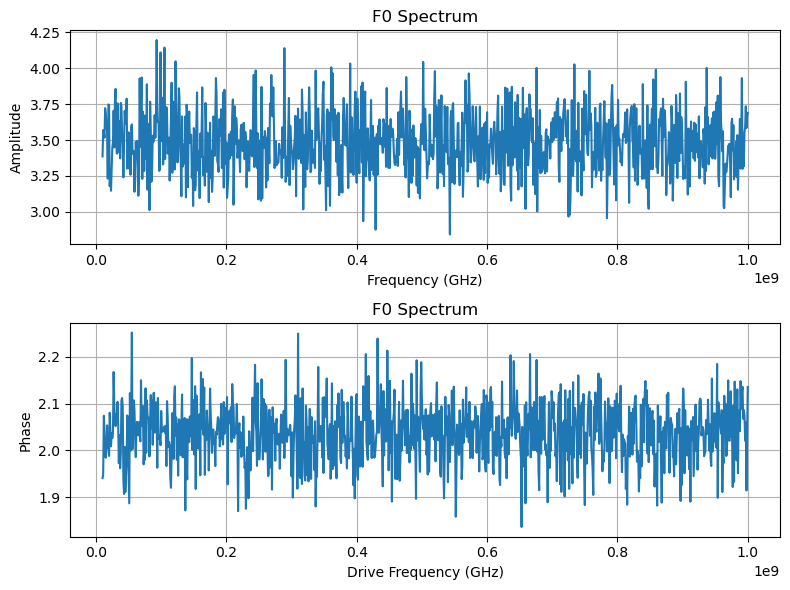

In [291]:
# For plotting current vs single resonator point
drive_freqs = my_acquired_results.axis[0]
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(drive_freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
ax[1].plot(drive_freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()

# Qubit T1

In [13]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=200e-6, count=20)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Delay_sweep',
        parameter=time_delay,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=qubit.parameters.user_defined['amplitude_pi']), #1,) #max power to start
            )
            exp.delay('drive', time_delay)
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

## Compile Session
Do final checks before running the job.

In [14]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [15]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [ 2.00581200e+04  3.60529227e+01 -1.30928387e+01]
T1 time 49.855121103510655 us


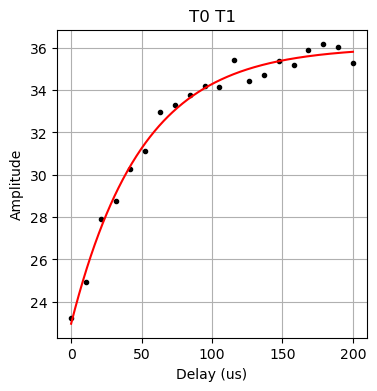

In [16]:
amplitude = np.abs(my_acquired_results.data)
phase = np.angle(my_acquired_results.data)

delay_plot = np.linspace(time_delay.start, time_delay.stop, 501)
popt, pcov = exponential_decay.fit(time_delay, amplitude, 1/40e-6, 10, 7, plot=False)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(time_delay*1e6, amplitude, '.k')
ax.plot(delay_plot*1e6, exponential_decay(delay_plot, *popt), '-r');
ax.set_title(f'{qubit.uid} T1')
ax.set_xlabel('Delay (us)')
ax.set_ylabel('Amplitude')
ax.grid()

print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

## T1 Statistics

In [18]:
def t1_run():
    time_delay = LinearSweepParameter(
        uid='time_delay', start=0, stop=200e-6, count=40)
    
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
        ):
            with exp.section(uid='Play drive'):
                exp.play(
                    signal="drive",
                    pulse=pulse_library.gaussian_square(
                        uid=f"drive_spec_pulse_{qubit.uid}",
                        length=qubit.parameters.user_defined["pulse_length"],
                        amplitude=qubit.parameters.user_defined['amplitude_pi']), #1,) #max power to start
                )
                exp.delay('drive', time_delay)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    session = Session(
        device_setup=device_setup,
        log_level = logging.WARNING,
        experiment=exp)
    session.connect();
    compiled_session = session.compile(exp);
    # psv.interactive_psv(compiled_session, max_events_to_publish=100,)
    
    results = session.run()
    my_results = session.get_results() #a deep copy of session.results
    my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

    
    amplitude = np.abs(my_acquired_results.data)
    popt, pcov = exponential_decay.fit(time_delay, amplitude, 1/40e-6, 10, 7, plot=False)
    return [popt[0], [popt, pcov]]

In [19]:
datetime_array, T1_data = measure_data_stats(t1_run, data_points=1000)

1 43.59031151726979
2 49.539424600914565
3 49.28848779016237
4 47.17289982650259
5 49.12679046507688
6 51.42147758203886
7 47.73873988914248
8 44.1648988217618
9 43.2896972156137
10 48.5028002129435
11 44.095536147861026
12 50.875754785241504
13 45.44675394588675
14 53.35896925519029
15 51.2223206045657
16 51.15399222769286
17 47.10124937079568
18 42.930048702325884
19 47.30596221012932
20 49.855580133117336
21 47.30622557405092
22 44.40756451065304
23 51.87285318462945
24 42.806549380817806
25 49.190682171189444
26 49.42013007955113
27 46.22899975233128
28 52.698914902528195
29 46.97579070306008
30 54.546413983225406
31 42.85826066346265
32 47.34624007370115
33 59.26914027049681
34 46.294448021364055
35 49.44776197865064
36 54.237227023890114
37 51.541615887450334
38 48.677689095924194
39 55.594956826859395
40 52.05835567080209
41 48.65136231867509
42 47.85393404459131
43 50.602616312584914
44 44.082756570596075
45 48.35440234413566
46 47.61223265538271
47 46.36160762711805
48 54.6136

T1  =  51.8429839210567 +/- 5.638021335624926


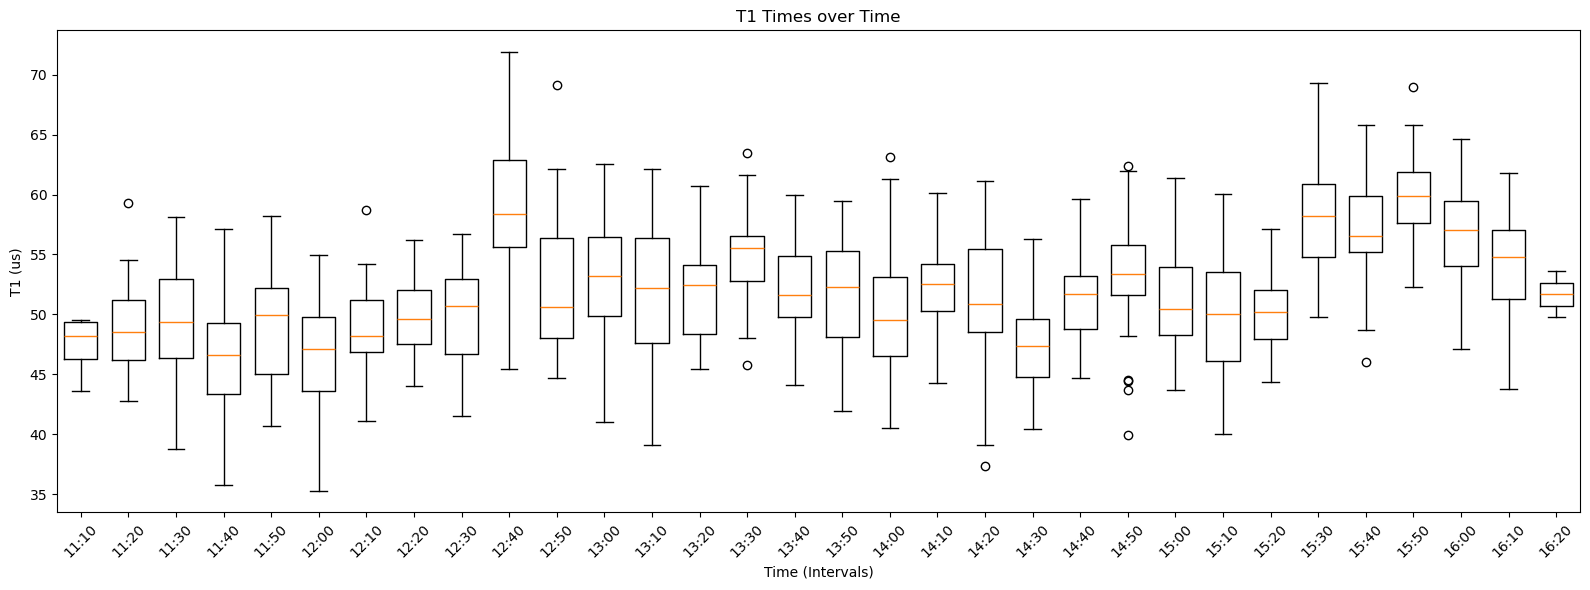

In [30]:
stat_out(1/T1_data*1e6, 'T1')
plot_box_whisker_time_series(datetime_array, 1/T1_data*1e6, 'T1', time_interval_str='10min')

# Qubit Rabi Amplitude Sweep (X Gate Tuneup)

In [55]:
rabi_amp_sweep = LinearSweepParameter(
    uid='rabi_amplitude', start=0, stop=1, count=101)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Amplitude Sweep',
        parameter=rabi_amp_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"], #can have this be longer if not enough periods
                    amplitude=1,), #max power to start
                amplitude=rabi_amp_sweep,
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

## Compile Session
Do final checks before running the job.

In [56]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [57]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [ 3.95302364 -3.38410848 -6.12117729 28.83009275]


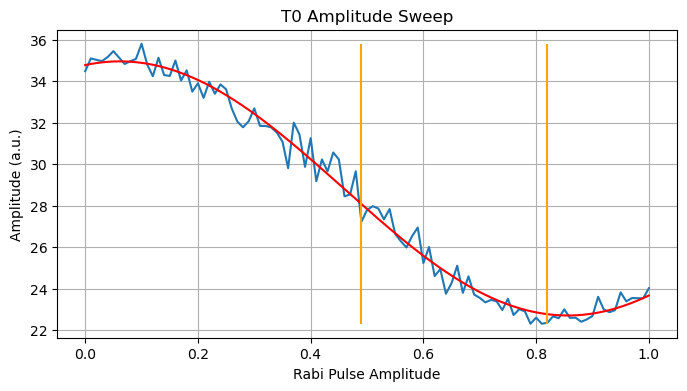

In [59]:
# plot measurement data
drive_amp = my_acquired_results.axis[0]
rabi_data = my_acquired_results.data
rabi_data_abs = np.abs(rabi_data)
rabi_data_phase = np.angle(rabi_data)

fitting_plot_x = np.linspace(rabi_amp_sweep.start, rabi_amp_sweep.stop, 501)
popt, pcov = oscillatory.fit(drive_amp, rabi_data_abs, 2, -3, 0, 8, plot=False)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(drive_amp, rabi_data_abs)
ax.plot(fitting_plot_x, oscillatory(fitting_plot_x, *popt), '-r')
ax.set_title(f'{qubit.uid} Amplitude Sweep')
ax.set_xlabel('Rabi Pulse Amplitude')
ax.set_ylabel('Amplitude (a.u.)')
ax.vlines(0.49, ymin=np.min(rabi_data_abs), ymax=np.max(rabi_data_abs), color='orange')
ax.vlines(0.82, ymin=np.min(rabi_data_abs), ymax=np.max(rabi_data_abs), color='orange')
ax.grid()
print(f"Fitted parameters: {popt}")

# Qubit Ramsey

In [103]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=60e-6, count=201)

ramsey_drive = pulse_library.gaussian_square(
    uid='ramsey_drive',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2'],
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Delay_sweep',
        parameter=time_delay,
    ):
        with exp.section(uid='Play drive'):
            exp.play(signal="drive", pulse=ramsey_drive)
            exp.delay('drive', time_delay)
            exp.play(signal="drive", pulse=ramsey_drive)
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.drive_frequency_ge+0.5e6, #offset here of about 1MHz to 3MHz to get precise frequency
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [104]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [105]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [2.92476145e+06 3.46276214e+00 3.31102359e+04 2.98063950e+00
 5.21143581e+00]
detuning = 2.924761453616276 MHz, T2r = 30.20214059580884 us


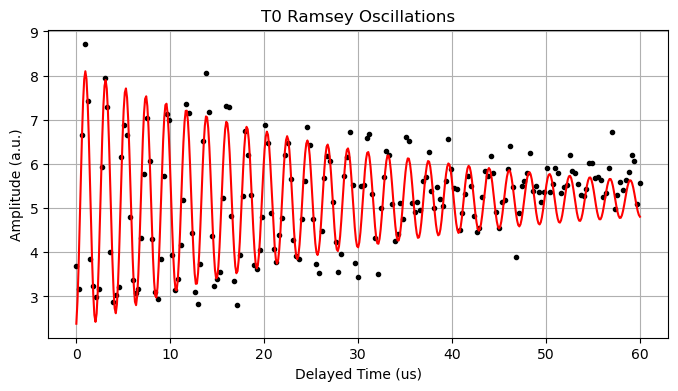

In [106]:
ramsey_data = my_acquired_results.data
ramsey_data_abs = np.abs(ramsey_data)
ramsey_data_phase = np.angle(ramsey_data)

fitting_plot_x = np.linspace(time_delay.start, time_delay.stop, 501)
popt, pcov = oscillatory_decay.fit(time_delay, ramsey_data_abs, 2.93024450e+06, 3.45453279e+00, 1.84843708e+04, 2.93235930e+00, 5.01709506e+00, plot=False)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time_delay*1e6, ramsey_data_abs, '.k')
ax.plot(fitting_plot_x*1e6, oscillatory_decay(fitting_plot_x, *popt), '-r')
ax.set_title(f'{qubit.uid} Ramsey Oscillations')
ax.set_xlabel('Delayed Time (us)')
ax.set_ylabel('Amplitude (a.u.)')
ax.grid()

print(f'Fitted parameters: {popt}')
#NOTE: you need to divide the detuning by 2pi when adjusting for later measurements
print(f'detuning = {popt[0]*1e-6} MHz, T2r = {1e6/popt[2]} us')

## Ramsey Statistics

In [110]:
def ramsey_run():
    time_delay = LinearSweepParameter(
        uid='time_delay', start=0, stop=60e-6, count=201)
    
    ramsey_drive = pulse_library.gaussian_square(
        uid='ramsey_drive',
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi/2'],
    )
    
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
        ):
            with exp.section(uid='Play drive'):
                exp.play(signal="drive", pulse=ramsey_drive)
                exp.delay('drive', time_delay)
                exp.play(signal="drive", pulse=ramsey_drive)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge+0.5e6, #offset here of about 1MHz to 3MHz to get precise frequency
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,)
    exp.set_calibration(exp_calibration)
    
    session = Session(
        device_setup=device_setup,
        log_level = logging.WARNING,
        experiment=exp)
    session.connect();
    compiled_session = session.compile(exp);
    
    results = session.run()
    my_results = session.get_results() #a deep copy of session.results
    my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name
    
    ramsey_data = my_acquired_results.data
    ramsey_data_abs = np.abs(ramsey_data)
    ramsey_data_phase = np.angle(ramsey_data)
    
    popt, pcov = oscillatory_decay.fit(time_delay, ramsey_data_abs, 2.92476145e+06, 3.46276214e+00, 3.31102359e+04, 2.98063950e+00, 5.21143581e+00, plot=False)
    
    print(f'Fitted parameters: {popt}')
    #NOTE: you need to divide the detuning by 2pi when adjusting for later measurements
    print(f'detuning = {popt[0]*1e-6} MHz, T2r = {1e6/popt[2]} us')
    return [popt[2], [popt, pcov]] 

In [111]:
datetime_array, T2star_data = measure_data_stats(ramsey_run, data_points=100)

Fitted parameters: [2.92222600e+06 3.43455340e+00 3.08848822e+04 3.05704499e+00
 5.29429559e+00]
detuning = 2.9222259963508694 MHz, T2r = 32.37830063351303 us
1 32.37830063351303
Fitted parameters: [2.91392105e+06 3.66824426e+00 3.41145947e+04 2.51365186e+00
 5.23047266e+00]
detuning = 2.9139210453209046 MHz, T2r = 29.31296735856162 us
2 29.31296735856162
Fitted parameters: [2.92211209e+06 3.40596381e+00 2.69352648e+04 3.09979143e+00
 5.32229179e+00]
detuning = 2.9221120856079597 MHz, T2r = 37.126050502617524 us
3 37.126050502617524
Fitted parameters: [2.92549699e+06 3.37966512e+00 3.01303444e+04 3.43052272e+00
 5.38444882e+00]
detuning = 2.925496985181767 MHz, T2r = 33.18913278959417 us
4 33.18913278959416
Fitted parameters: [2.92426385e+06 3.43629125e+00 2.97916934e+04 3.27476008e+00
 5.25733232e+00]
detuning = 2.924263852838638 MHz, T2r = 33.56640346520259 us
5 33.56640346520259
Fitted parameters: [2.92524382e+06 3.39989670e+00 2.89773101e+04 3.40289140e+00
 5.35151334e+00]
detuning

T2*  =  32.404021537521345 +/- 2.568994594327005


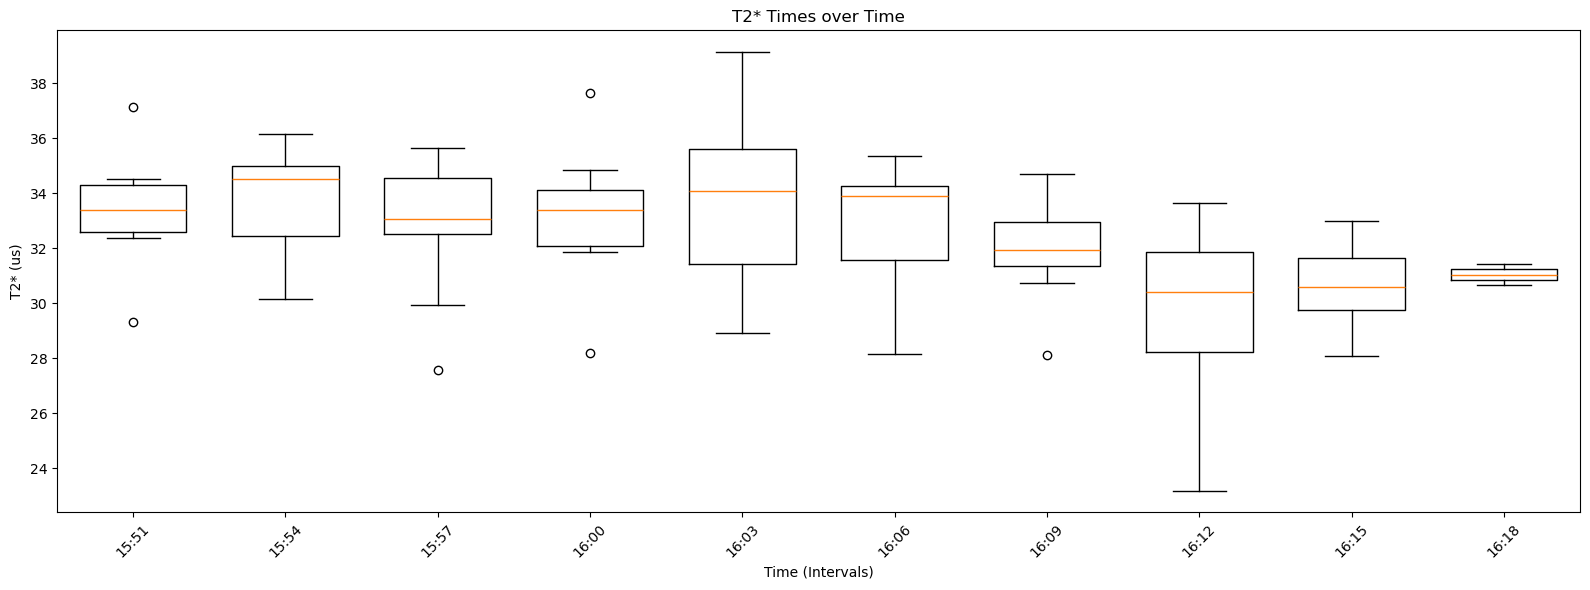

In [115]:
stat_out(1/T2star_data*1e6, 'T2*')
plot_box_whisker_time_series(datetime_array, 1/T2star_data*1e6, 'T2*', time_interval_str='3min')

# T2 Echo

In [ ]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=40e-6, count=51)

x90 = pulse_library.gaussian_square(
    uid='x90',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2']
)

x180 = pulse_library.gaussian_square(
    uid='x180',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi']
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
    reset_oscillator_phase=True
):
    with exp.sweep(
        uid='Delay_sweep',
        parameter=time_delay,
        alignment=SectionAlignment.RIGHT,
        reset_oscillator_phase=True
    ):
        with exp.section(uid='Play drive', alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", phase=0, pulse=x90)
            exp.delay('drive', time_delay/2)
            exp.play(signal="drive", phase=0, pulse=x180)
            exp.delay('drive', time_delay/2)
            exp.play(signal='drive', phase=0, pulse=x90)
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.drive_frequency_ge+1e6-0.965e6,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [ ]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [ ]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data
WOAAAH that's super strange... The data seems to behave very differently before vs after 50us wait time!

Fitted parameters: [9.58073817e+04 4.31432800e+00 7.56117261e+00]
T2e time 10.437609111394925 us


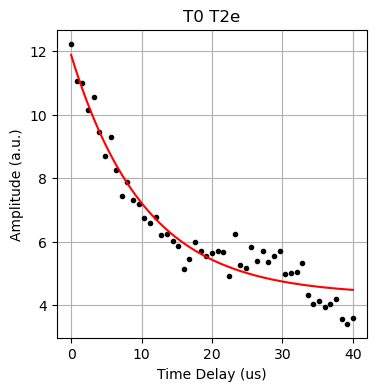

In [315]:
echo_data = my_acquired_results.data
echo_data_abs = np.abs(echo_data)
echo_data_phase = np.angle(echo_data)

popt, pcov = exponential_decay.fit(time_delay, echo_data_abs, (1/10e-6), -20, -20, plot=False)
fit_plotting_x = np.linspace(time_delay.start, time_delay.stop, 501)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(time_delay*1e6, echo_data_abs, '.k')
ax.plot(fit_plotting_x*1e6, exponential_decay(fit_plotting_x, *popt), '-r')
ax.set_title(f'{qubit.uid} T2e')
ax.set_xlabel('Time Delay (us)')
ax.set_ylabel('Amplitude (a.u.)')
ax.grid()

print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

## T2E Statistics

In [304]:
def T2E_run():
    time_delay = LinearSweepParameter(
        uid='time_delay', start=0, stop=50e-6, count=51)
    
    x90 = pulse_library.gaussian_square(
        uid='x90',
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi/2']
    )
    
    x180 = pulse_library.gaussian_square(
        uid='x180',
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']
    )
    
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        reset_oscillator_phase=True
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
            alignment=SectionAlignment.RIGHT,
            reset_oscillator_phase=True
        ):
            with exp.section(uid='Play drive', alignment=SectionAlignment.RIGHT):
                exp.play(signal="drive", phase=0, pulse=x90)
                exp.delay('drive', time_delay/2)
                exp.play(signal="drive", phase=0, pulse=x180)
                exp.delay('drive', time_delay/2)
                exp.play(signal='drive', phase=0, pulse=x90)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge+1e6-0.965e6, #THIS MAY NEED TO BE SUBTLEY ADJUSTED BASED ON RAMSEY
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,)
    exp.set_calibration(exp_calibration)

    session = Session(
        device_setup=device_setup,
        log_level = logging.WARNING,
        experiment=exp)
    session.connect();
    compiled_session = session.compile(exp);
    
    results = session.run()
    my_results = session.get_results() #a deep copy of session.results
    my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name
    
    echo_data = my_acquired_results.data
    echo_data_abs = np.abs(echo_data)
    echo_data_phase = np.angle(echo_data)
    
    popt, pcov = exponential_decay.fit(time_delay, echo_data_abs, 3.94114308e+04, 1.15779379e+00, 1.14347287e+01, plot=False)
    
    print(f"Fitted parameters: {popt}")
    print('T2e time ' + str(1/popt[0]*1e6) + ' us') 
    return [popt[0], [popt, pcov]]

In [305]:
datetime_array, T2E_data = measure_data_stats(T2E_run, data_points=50)

Fitted parameters: [1.91322672e+05 3.87176712e+00 9.26786658e+00]
T2e time 5.226772081189954 us
1 5.226772081189954
Fitted parameters: [ 2.61756598e+04 -2.47100520e-01  1.21225627e+01]
T2e time 38.20343048313458 us
2 38.20343048313458
Fitted parameters: [5.34690947e+05 5.15143295e+00 8.19364537e+00]
T2e time 1.8702392567348938 us
3 1.8702392567348938


TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

T1 =  53.52816909305005 +/- 2.3767529020002245


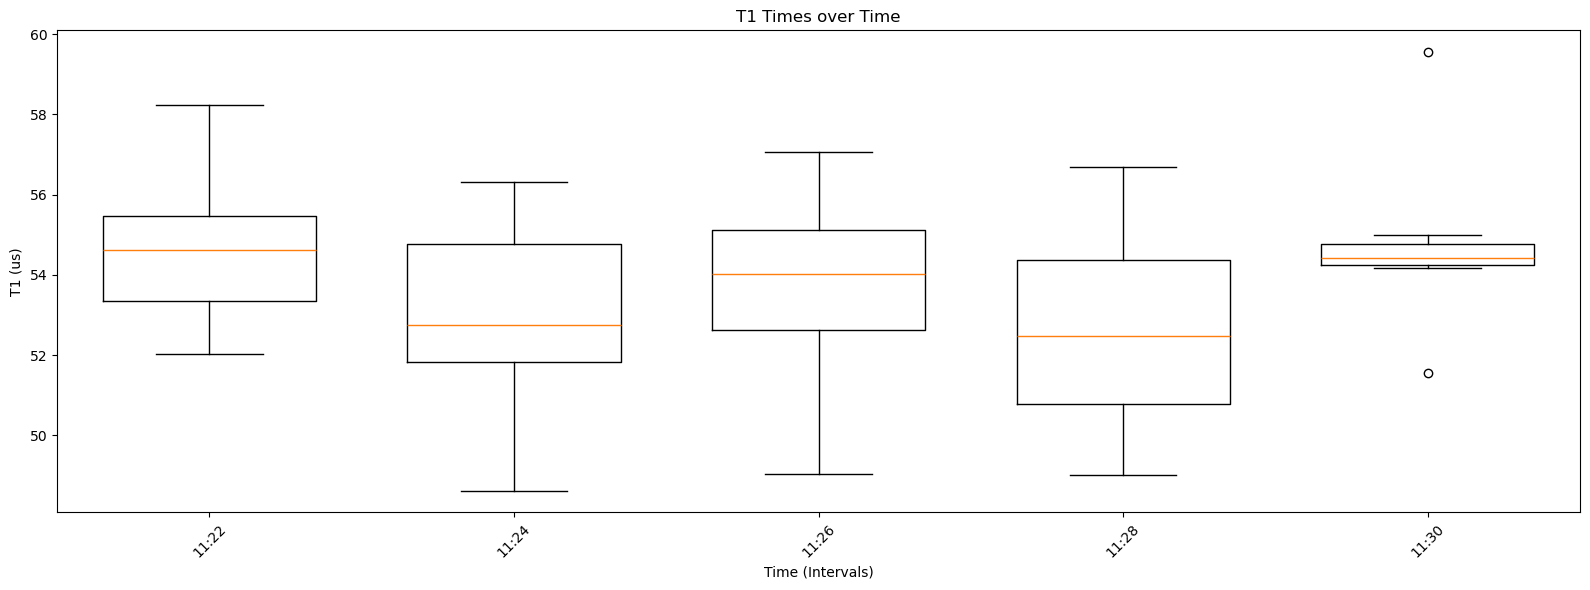

In [302]:
stat_out(1/T2E_data*1e6)
plot_box_whisker_time_series(datetime_array, 1/T2E_data*1e6, 'T1', time_interval_str='2min')

# Spectrum vs Flux (WORK IN PROGRESS -- NOT FIT FOR RUNNING)

In [85]:
drive_lo_freq_sweep = LinearSweepParameter(
    uid='Drive_LO', start=1e9, stop=8e9, count=8)

drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency', start=-500e6, stop=498e6, count=500)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Sweep Drive LO',
    parameter=drive_lo_freq_sweep
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Drive Frequency Sweep',
            parameter=drive_freq_sweep,
        ):
            with exp.section(uid='Play drive'):
                exp.play(
                    signal="drive",
                    pulse=pulse_library.gaussian_square(
                    uid=f"drive_pulse_{qubit.uid}",
                    length=100e-9,
                    width=100e-9*0.9,
                    sigma=0.2,
                    marker = {"marker1": {"enable": True}}))
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
drive_lo = Oscillator(
    'drive_lo',
    frequency=drive_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,
    local_oscillator=drive_lo)
exp.set_calibration(exp_calibration)

In [ ]:
## Compile Session
Do final checks before running the job.

In [81]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [82]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [83]:
drive_lo_array = my_acquired_results.axis[0]
drive_AWG_freqs = my_acquired_results.axis[1]
drive_freqs = np.empty((0))
for drive_lo in drive_lo_array:
    drive_freqs = np.append(drive_freqs, drive_lo + drive_AWG_freqs,)

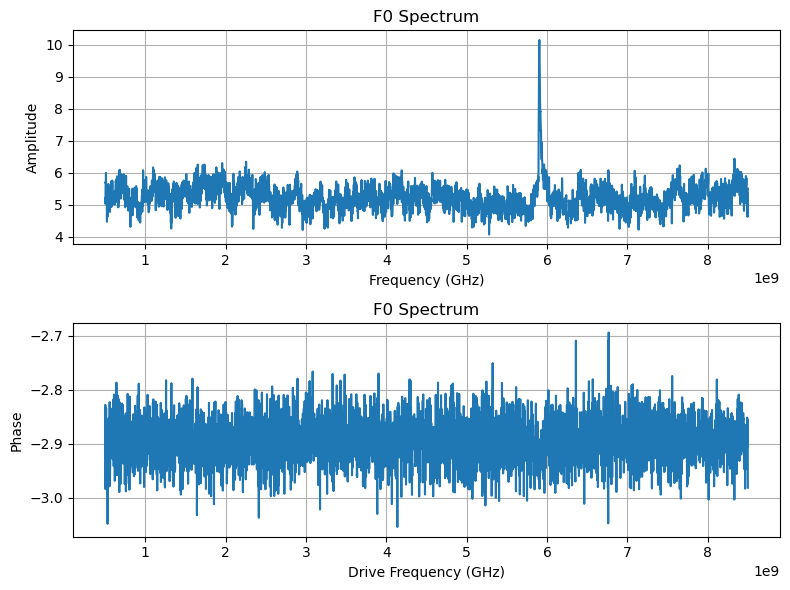

In [84]:
# For plotting current vs single resonator point
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(drive_freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
ax[1].plot(drive_freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()

# Qubit Spectroscopy Power Sweep (Nice-to-have but skip for now)